In [1]:
#IMPORT THE PACKAGES
import os, keras, cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime
from keras import layers, losses, callbacks, activations, regularizers, metrics, applications, optimizers

In [2]:
#LOAD THE DATA
data = os.path.join(os.getcwd(),'dataset')
BATCH_SIZE = 10
IMG_SIZE = (160, 160)
train_d, val_d = keras.utils.image_dataset_from_directory(data,
                                                          shuffle=True,
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE,
                                                          validation_split=0.3,
                                                          subset='both',
                                                          seed=42)

Found 3699 files belonging to 8 classes.
Using 2590 files for training.
Using 1109 files for validation.


['Blazer', 'Denim_Jacket', 'Hoodie', 'Jeans', 'Shorts', 'T shirt', 'button_shirts', 'long_pants']


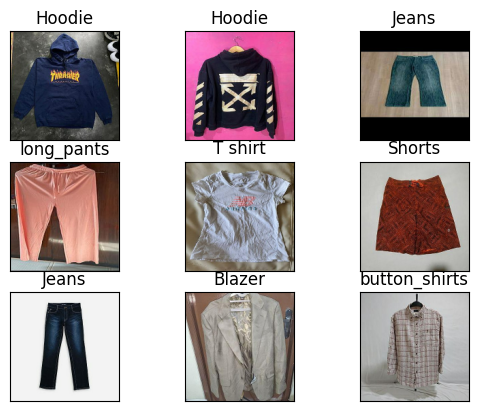

In [3]:
#plot the images
class_names = train_d.class_names
print(class_names)
batch_1 = train_d.take(1)
for feature, label in batch_1:
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(feature[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
    plt.show()

In [4]:
#Convert the val dataset back to PrefetchDataset
val_d = val_d.prefetch(buffer_size=tf.data.AUTOTUNE)

In [5]:
#Create a sequential model for augmentation
data_aug = keras.Sequential()
data_aug.add(layers.RandomFlip())
data_aug.add(layers.RandomRotation(factor=0.2))

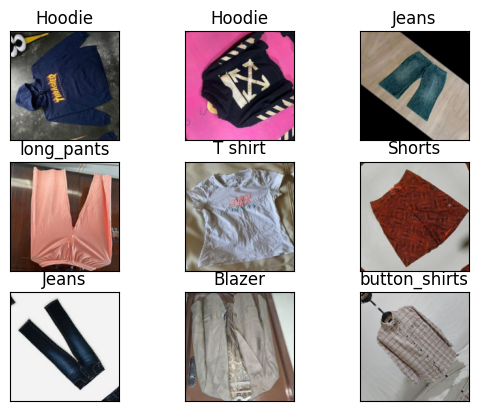

In [6]:
# Test feature augmentation
feature_augmented = data_aug(feature)
for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(feature_augmented[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
plt.show()

In [7]:
# Create the preprocessing layer based on the pretrained model that we will use
preprocess_input = applications.mobilenet_v2.preprocess_input

In [8]:
# apply transfer learning using pretrained model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet',alpha=0.5)
# freeze the feature extractor to make sure we only train the classifier
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_0.50_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        432 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │         64 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        144 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80, 8) │        128 │ expanded_conv_de… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80, 8) │         32 │ expanded_conv_pr… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │        384 │ expanded_conv_pr… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        192 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        432 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        192 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │        768 │ block_1_depthwis

 Total params: 706,224 (2.69 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 706,224 (2.69 MB)

In [9]:
# construct classifier
global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(len(class_names), activation='softmax')

In [10]:
# use functional api to connect all layers
inputs = keras.Input(shape=IMG_SHAPE)
# augmentation layers
x = data_aug(inputs)
# preprocessing layer
x = preprocess_input(x)
# feature extractor
x = base_model(x)
# classifier
x = global_avg(x)
outputs = output_layer(x)
# create model
model = keras.Model(inputs = inputs, outputs= outputs)
model.summary()
keras.utils.plot_model(model=model)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_0.50_160            │ (None, 5, 5, 1280)     │       706,224 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 716,472 (2.73 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 706,224 (2.69 MB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [11]:
# compile model
optimizer = optimizers.Adam(learning_rate=0.001)
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer= optimizer, loss=loss, metrics=['accuracy'])

In [12]:
# train model
stop = keras.callbacks.EarlyStopping(patience=3,verbose=1,start_from_epoch=5)
epochs = 15
history_first = model.fit(train_d, validation_data=val_d, epochs=epochs,callbacks=stop)

Epoch 1/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.4505 - loss: 1.6017 - val_accuracy: 0.7196 - val_loss: 0.7867
Epoch 2/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.7347 - loss: 0.7919 - val_accuracy: 0.7800 - val_loss: 0.6312
Epoch 3/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 39s 149ms/step - accuracy: 0.7710 - loss: 0.6889 - val_accuracy: 0.7971 - val_loss: 0.5947
Epoch 4/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 35s 136ms/step - accuracy: 0.7977 - loss: 0.6339 - val_accuracy: 0.7881 - val_loss: 0.6005
Epoch 5/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 32s 122ms/step - accuracy: 0.8023 - loss: 0.5986 - val_accuracy: 0.7944 - val_loss: 0.5899
Epoch 6/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 39s 148ms/step - accuracy: 0.8191 - loss: 0.5508 - val_accuracy: 0.8016 - val_loss: 0.5793
Epoch 7/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 38s 145ms/step - accuracy: 0.8165 - loss: 0.5194 - val_accuracy: 0.8088 - val_loss: 0.5867
Epoch 8/15
259/259 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - accuracy: 0.8315 - loss: 0

In [13]:
# Evaluate the model after the first stage training
model.evaluate(val_d)

111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.7901 - loss: 0.6074


[0.5987613201141357, 0.7944093942642212]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
['Shorts', 'Hoodie', 'T shirt', 'Blazer', 'long_pants', 'Blazer', 'Shorts', 'button_shirts', 'button_shirts', 'button_shirts']


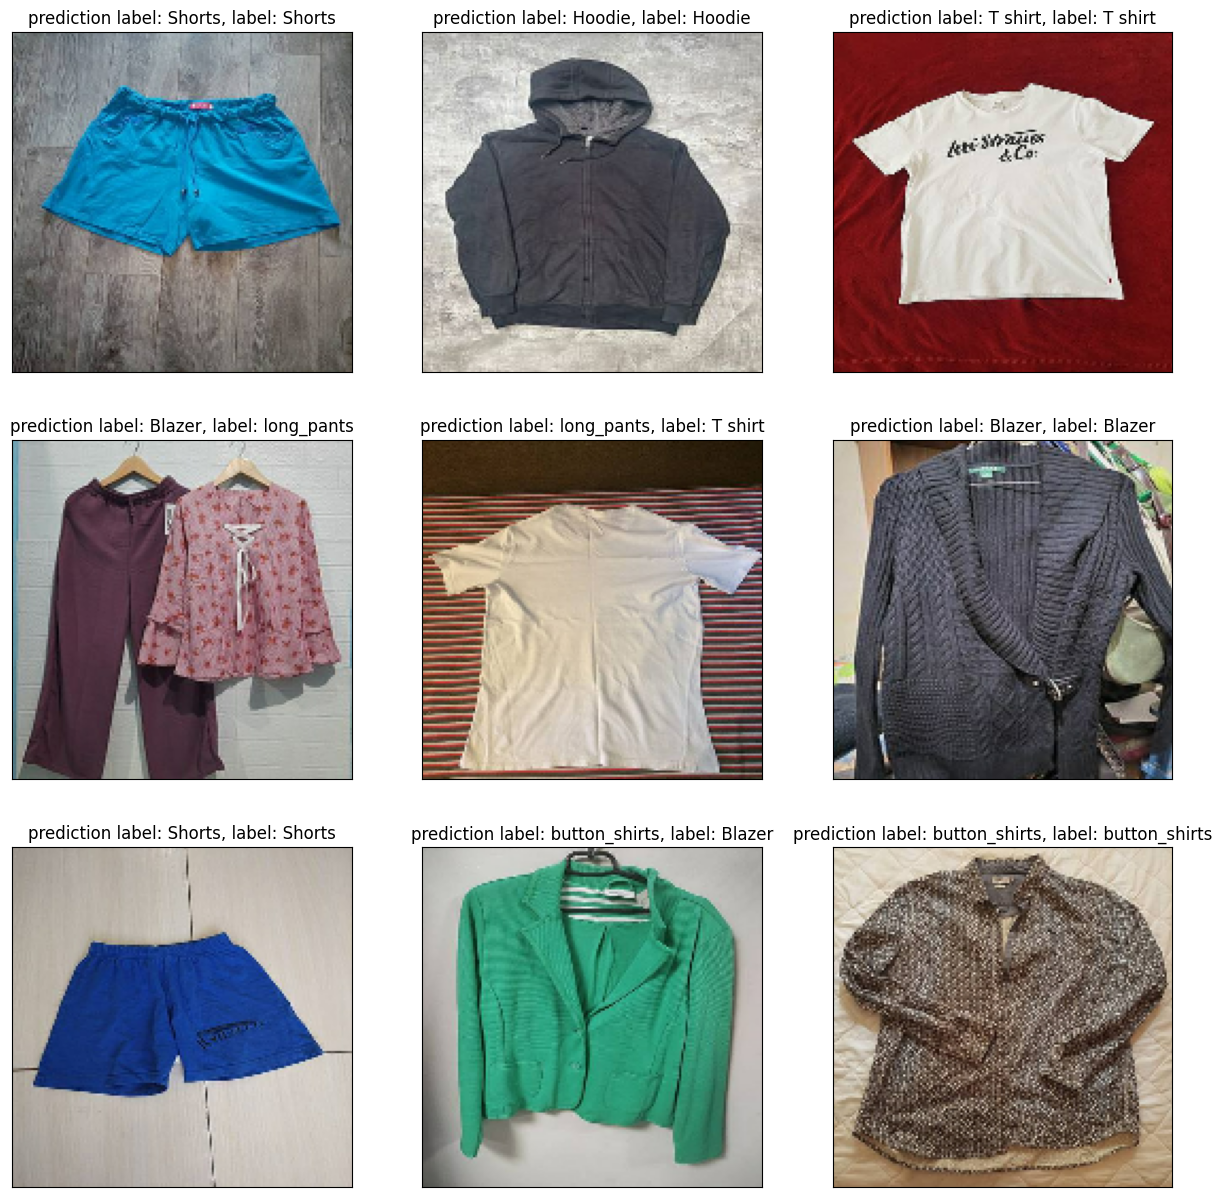

In [14]:
#make a prediction
for image_batch, label_batch in val_d.take(1):
    y_pred = np.argmax(model.predict(image_batch),axis=1)
    predicted_class = [class_names[x] for x in y_pred]
print(predicted_class)

plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(f'prediction label: {predicted_class[i]}, label: {class_names[label_batch[i]]}')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.show()

In [15]:
# 2nd stage transfer learning
# unfreeze model
base_model.trainable = True
# free earlier model of the base model
finetune_at = 100
for layer in base_model.layers[:finetune_at]:
    layer.trainable = False
base_model.summary()

Model: "mobilenetv2_0.50_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        432 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │         64 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        144 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80, 8) │        128 │ expanded_conv_de… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80, 8) │         32 │ expanded_conv_pr… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │        384 │ expanded_conv_pr… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        192 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        432 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        192 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │        768 │ block_1_depthwis

 Total params: 706,224 (2.69 MB)

 Trainable params: 584,864 (2.23 MB)

 Non-trainable params: 121,360 (474.06 KB)

In [16]:

second_epochs = 20
total_epochs = epochs + second_epochs
starting_epoch = history_first.epoch[-1] + 1
history_second = model.fit(train_d, validation_data=val_d, epochs=total_epochs, batch_size=BATCH_SIZE, initial_epoch=starting_epoch,callbacks=stop)


Epoch 12/35
259/259 ━━━━━━━━━━━━━━━━━━━━ 40s 156ms/step - accuracy: 0.8414 - loss: 0.4569 - val_accuracy: 0.7926 - val_loss: 0.6201
Epoch 13/35
259/259 ━━━━━━━━━━━━━━━━━━━━ 38s 146ms/step - accuracy: 0.8631 - loss: 0.4118 - val_accuracy: 0.7935 - val_loss: 0.6158
Epoch 14/35
259/259 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - accuracy: 0.8614 - loss: 0.4036 - val_accuracy: 0.7809 - val_loss: 0.6526
Epoch 15/35
259/259 ━━━━━━━━━━━━━━━━━━━━ 40s 152ms/step - accuracy: 0.8526 - loss: 0.3962 - val_accuracy: 0.7872 - val_loss: 0.6344
Epoch 16/35
259/259 ━━━━━━━━━━━━━━━━━━━━ 33s 125ms/step - accuracy: 0.8638 - loss: 0.3851 - val_accuracy: 0.7998 - val_loss: 0.6306
Epoch 16: early stopping


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
['Shorts', 'Hoodie', 'T shirt', 'button_shirts', 'button_shirts', 'Blazer', 'Shorts', 'button_shirts', 'button_shirts', 'button_shirts']


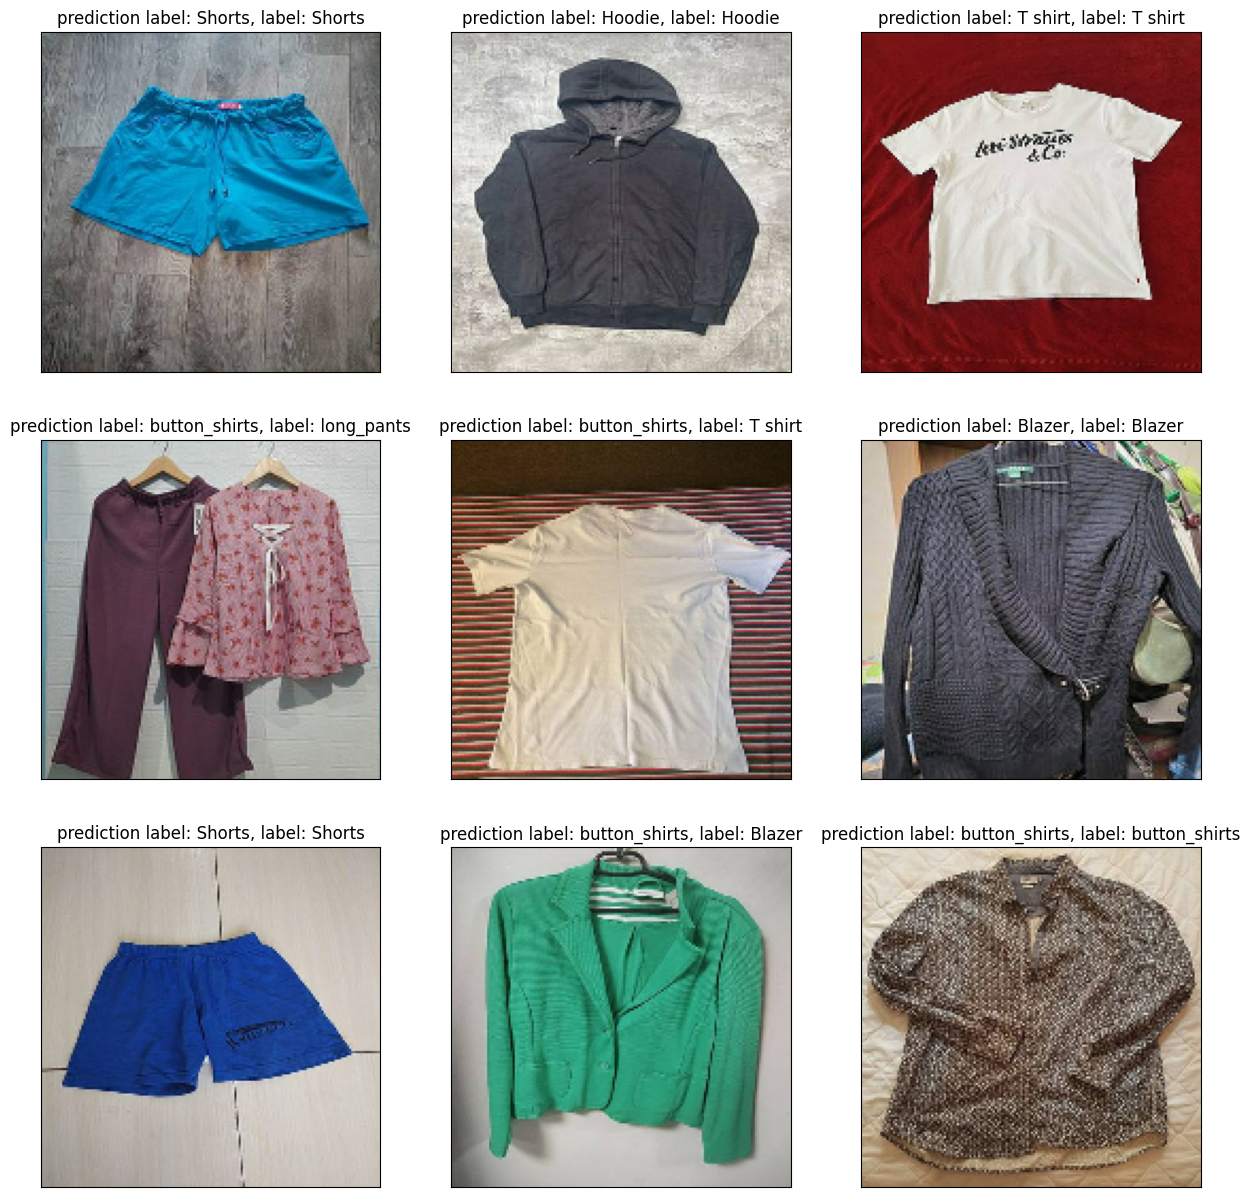

In [17]:
#make a prediction
for image_batch, label_batch in val_d.take(1):
    y_pred = np.argmax(model.predict(image_batch),axis=1)
    predicted_class = [class_names[x] for x in y_pred]
print(predicted_class)

plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(f'prediction label: {predicted_class[i]}, label: {class_names[label_batch[i]]}')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.show()

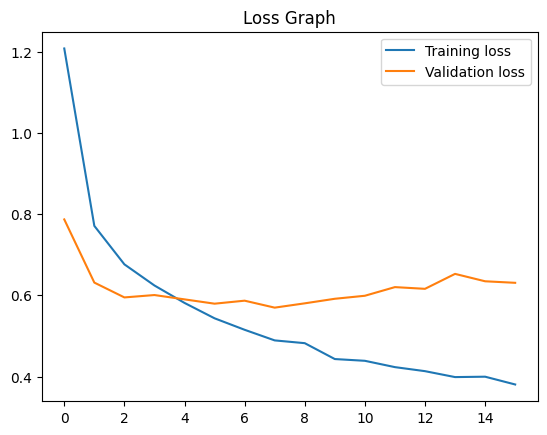

In [26]:
plt.plot(history_first.history['loss']+history_second.history['loss'])
plt.plot(history_first.history['val_loss']+history_second.history['val_loss'])
plt.title('Loss Graph')
plt.legend(['Training loss','Validation loss'])
plt.show()

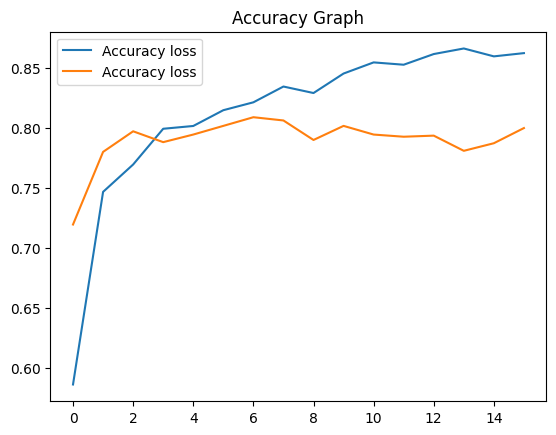

In [25]:
plt.plot(history_first.history['accuracy']+ history_second.history['accuracy'])
plt.plot(history_first.history['val_accuracy']+history_second.history['val_accuracy'])
plt.title('Accuracy Graph')
plt.legend(['Accuracy loss','Accuracy loss'])
plt.show()

In [22]:
#save keras model
model_filepath = os.path.join(os.getcwd(),'models','model.keras')
model.save(model_filepath, overwrite=True, zipped=None)